# RUN PERFORMANCE PROJECT - Pau Sampietro 

## *Predicting future races:* WEIGHTED LINEAR REGRESSION ALGORITHM

Both of the previous algorithms (LR and KNN) perform a regression without taking into account how old or recent the moves are. If, for exemple, we perform two different times for the same race in two consecutive years, the model does not weight as more relevant the most recent move, and it should be (as the time has an influence on the performance).

For that reason, we decide to try a linear regression (that provided us better results) but considering now **that the most recent moves are more relevant than the older ones**, which means **weighting our regression**. We will consider this equation to calculate weights:

 > **W = K * exp(-timeElapsed/T)**

*where K is a scaling constant and T is the time-constant for the decay function. time Elapsed is measured as days from the move has been done. W works as case-weight* 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.plotly as py
import matplotlib.pyplot as plt
import cufflinks as cf 
from ipywidgets import interact
import plotly.graph_objs as go
from rpdb import read_table, read_table_sql, export_table
from datetime import datetime

#### Import table moves from Pau from the Database

In [3]:
moves = read_table('moves_feat')

In [5]:
moves.drop(columns='index', inplace=True)
moves.head()

,distance,accum_ascent,ascent_ratio,calories,heart_rate,days_from,moving_time
0,4019.0,280.0,69.7,670.0,166.0,659,29.8
1,4995.0,63.0,12.6,585.0,168.0,659,30.9
2,4374.0,115.0,26.3,602.0,180.0,642,22.6
3,3005.0,91.0,30.3,365.0,167.0,641,16.9
4,6540.0,241.0,36.9,760.0,161.0,637,42.0


### 1. Adding weights to the model 

#### 1.1. Computing and Plotting weights based on "days_from" column

Loop through many weight functions to find the optimal parameter T. We force that:
* **weight = 1** for a move done today
* **weight = 0.5** for a move done 1 year from now

Choosen parameter K is: 1
Choosen parameter T is: 526


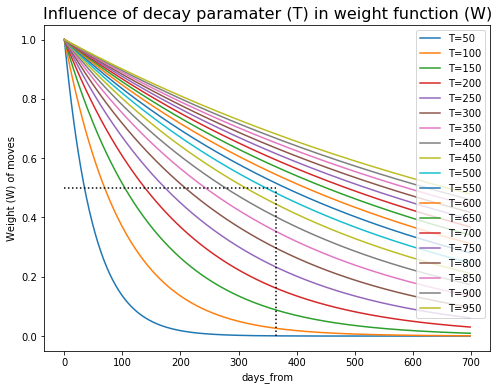

In [75]:
plt.figure(figsize=(8,6))

K = 1
x = [i for i in range(0,700)]
for T in range(50,1000,50):
    y = [K * np.exp(-i/T) for i in x]
    plt.plot(x, y)

plt.title('Influence of decay paramater (T) in weight function (W)', fontsize=16)
plt.legend([f'T={i}' for i in range(50,1000,50)], loc=1)
plt.plot(range(365),[0.5 for i in range(365)], 'black', linestyle=':')
plt.plot([365 for i in range(100)], [0.005*i for i in range(100)], 'black', linestyle=':')
plt.ylabel('Weight (W) of moves')
plt.xlabel('days_from')

# Printing the choosen parameters
print(f'Choosen parameter K is: {K}')
print(f'Choosen parameter T is: {int(-365/np.log(0.5))}')

#### 1.2. Applying decayment function with choosen parameters K,T

In [60]:
moves['W'] = moves.apply(lambda x: K * np.exp(-x['days_from']/T), axis = 1)

In [63]:
moves.head()

,distance,accum_ascent,ascent_ratio,calories,heart_rate,days_from,moving_time,W
0,4019.0,280.0,69.7,670.0,166.0,659,29.8,0.499732
1,4995.0,63.0,12.6,585.0,168.0,659,30.9,0.499732
2,4374.0,115.0,26.3,602.0,180.0,642,22.6,0.508755
3,3005.0,91.0,30.3,365.0,167.0,641,16.9,0.509290
4,6540.0,241.0,36.9,760.0,161.0,637,42.0,0.511439


# * ***We store the table with the weights ???***

In [9]:
export_table(moves, 'moves_weights', METHOD='replace')

### 2. Weighted Linear Regression Algorithm

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

The goal is to know what will be the times for two given races:
* Delta Prat Race: 10 km, 25 m ascent, 5 may 2019
* Marathon Catllaràs: 42 km, 2700 m ascent, 19 may 2019
* Stockholm Marathon: 42 km, 172 m ascent, 1 june 2019
* Trail Ulldeter: 21 km, 1300 m ascent, 23 june 2019

In [57]:
races = read_table('races')
races

,index,name,distance,accum_ascent,days_from
0,0,delta prat,10000.0,25.0,-13
1,1,catllaras,42300.0,2700.0,-27
2,2,stockholm,42195.0,172.0,-40
3,3,ulldeter,21000.0,1300.0,-62


#### 2.1. Applying linear regression with features weighted

In [76]:
# Selecting only given features for predictions
moves_fil = moves[['accum_ascent', 'distance', 'moving_time','W']]

X = moves_fil.drop(columns='moving_time')
y = moves_fil['moving_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 32)

In [77]:
lin_reg_W = LinearRegression()
lin_reg_W.fit(X_train.drop(columns='W'), y_train, sample_weight = X_train['W'])

# predictions done with the model
y_pred = lin_reg_W.predict(X_test.drop(columns='W'))

In [79]:
# The coefficients
print('Coefficients:', lin_reg_W.coef_)
# Printing the metrics for the model
print("* Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('* Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: [0.12104329 0.00326681]
* Mean squared error: 158.45
* Variance score: 0.88


*As we can see, the result of the r2 score is quite high. With a weighted model r2 decreases, but the data is still well explained by the model. On the other hand, we can not reduce MSE enough*

* Performing **cross-validation** score

In [80]:
scores = cross_val_score(lin_reg_W, X.drop(columns='W'),  y, cv=5)
print(f'* CV scores: {scores}')
print('* Mean Variance score: %.2f' % scores.mean())

* CV scores: [0.70754061 0.91185059 0.94255492 0.84742461 0.84566975]
* Mean Variance score: 0.85


#### 2.1. Calculating predictions for next given races with actual model:

In [83]:
lin_reg_W.fit(X.drop(columns='W'), y, sample_weight = X['W'])

races_lrW_pred = lin_reg_W.predict(races[['accum_ascent','distance']])
print(f'* LR predictions for given races: {races_lrW_pred}')

* LR predictions for given races: [ 35.98102858 459.35451827 160.1651677  223.1943718 ]


* Including results of Weighted linear regression predictions in the races dataframe

In [84]:
races = read_table('races')
races['lrW_pred'] = races_lrW_pred
export_table(races.drop(columns='index'), 'races')

*** *COMMENTS***: It's interesting to weight moves as their importance for predictions depends on how recent they are. However, as Pau is not consistently training with regularity, analyzing time decayment is neither providing the best results. We obtain similar conclusions than with ordinary linear regression:
* Cross-country races are predict very well. **Catllaras: 459 min ~ 7:40h / Ulldeter: 223 min ~ 3:50h** 
* Urban races are badly predicted **36 min for a 10 km** and **2:40h for a marathon**.